In [1]:
import numpy as np
import pandas as pd

In [2]:
#Loading Dataset

data_path = 'Steel_industry_data.csv'
#Pandas Library to create Dataframe
Steel_data = pd.read_csv(data_path, engine='python')

In [3]:
#First five rows of dataset
Steel_data.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [4]:
#Last five rows of dataset
Steel_data.tail()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
35035,31/12/2018 23:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,31/12/2018 23:15,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,31/12/2018 23:30,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,31/12/2018 23:45,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load
35039,31/12/2018 00:00,3.67,3.02,0.07,0.0,77.22,99.98,0,Weekday,Monday,Light_Load


In [5]:
Steel_data['date'] = pd.to_datetime(Steel_data['date'], format='%d/%m/%Y %H:%M')

Steel_data['year'] = Steel_data['date'].dt.year
Steel_data['month'] = Steel_data['date'].dt.month
Steel_data['day'] = Steel_data['date'].dt.day
Steel_data['hour'] = Steel_data['date'].dt.hour
Steel_data['minute'] = Steel_data['date'].dt.minute

Steel_data = Steel_data.drop(columns=['date'])

In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

Steel_data['WeekStatus'] = label_encoder.fit_transform(Steel_data['WeekStatus'])
Steel_data['Day_of_week'] = label_encoder.fit_transform(Steel_data['Day_of_week'])
Steel_data['Load_Type'] = label_encoder.fit_transform(Steel_data['Load_Type'])

In [7]:
from sklearn.preprocessing import MinMaxScaler
continuous_columns = ['Usage_kWh', 
                      'Lagging_Current_Reactive.Power_kVarh', 
                      'Leading_Current_Reactive_Power_kVarh', 
                      'CO2(tCO2)', 
                      'Lagging_Current_Power_Factor', 
                      'Leading_Current_Power_Factor', 
                      'NSM']
scaler = MinMaxScaler()
Steel_data[continuous_columns] = scaler.fit_transform(Steel_data[continuous_columns])

In [8]:
#Split dataset into train and test sets
train_size=int(len(Steel_data)*0.70)

train_data = Steel_data[:train_size]
test_data = Steel_data[train_size:]

In [9]:
print(f"Training data: {train_data.shape}")
print(f"Testing data: {test_data.shape}")

Training data: (24528, 15)
Testing data: (10512, 15)


In [10]:
#function to create data sequences
def create_dataset(dataset, timesteps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-timesteps):
        dataX.append(dataset[i:i+timesteps, 1:])
        dataY.append(dataset[i+timesteps, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
train_values = train_data.values
test_values = test_data.values

In [12]:
#Define number of time steps
timesteps = 95

#Create sequences
x_train, y_train = create_dataset(train_values, timesteps)
x_test, y_test = create_dataset(test_values, timesteps)
print(y_train)

[0.02175849 0.02035882 0.02449421 ... 0.32453238 0.35914238 0.35685202]


In [13]:
print(x_train.shape), print(y_train.shape)

(24433, 95, 14)
(24433,)


(None, None)

In [14]:
print(x_test.shape), print(y_test.shape)

(10417, 95, 14)
(10417,)


(None, None)

In [22]:
#Import tensorflow for stacked LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

In [23]:
from keras.optimizers import Adam

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(95,14)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')


In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 95, 128)        │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 95, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 95, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,073 (527.63 KB)

 Trainable params: 135,073 (527.63 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
import tensorflow as tf

In [25]:
history = model.fit(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=50,
    batch_size=64,
    verbose=1
)

Epoch 1/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 52s 132ms/step - loss: 0.0580 - val_loss: 0.0375
Epoch 2/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - loss: 0.0482 - val_loss: 0.0352
Epoch 3/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - loss: 0.0430 - val_loss: 0.0263
Epoch 4/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - loss: 0.0361 - val_loss: 0.0272
Epoch 5/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - loss: 0.0317 - val_loss: 0.0227
Epoch 6/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - loss: 0.0294 - val_loss: 0.0205
Epoch 7/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 51s 132ms/step - loss: 0.0269 - val_loss: 0.0203
Epoch 8/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - loss: 0.0265 - val_loss: 0.0242
Epoch 9/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - loss: 0.0256 - val_loss: 0.0197
Epoch 10/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 51s 133ms/step - loss: 0.0248 - val_loss: 0.0187
Epoch 11/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - loss: 0.0234 - val_loss: 0.0158
Epoch 12/50
382/382

In [26]:
print(history.history)

{'loss': [0.05344119668006897, 0.04790342226624489, 0.04039010405540466, 0.034205906093120575, 0.030731385573744774, 0.028640981763601303, 0.027064550668001175, 0.026145976036787033, 0.025246979668736458, 0.024485042318701744, 0.023597750812768936, 0.02342623844742775, 0.022793462499976158, 0.021857324987649918, 0.021127849817276, 0.020847119390964508, 0.02056647092103958, 0.02004203572869301, 0.019666781648993492, 0.019052421674132347, 0.01870831474661827, 0.018529092893004417, 0.018173709511756897, 0.01806897483766079, 0.017649050801992416, 0.01718324050307274, 0.01683930680155754, 0.016750739887356758, 0.016390759497880936, 0.015869885683059692, 0.015728062018752098, 0.01555489283055067, 0.01511319074779749, 0.015067475847899914, 0.014775227755308151, 0.014787733554840088, 0.014070596545934677, 0.014192678965628147, 0.013773989863693714, 0.013968992978334427, 0.013474538922309875, 0.013563049025833607, 0.012936190702021122, 0.0129283107817173, 0.012766038998961449, 0.012539488263428

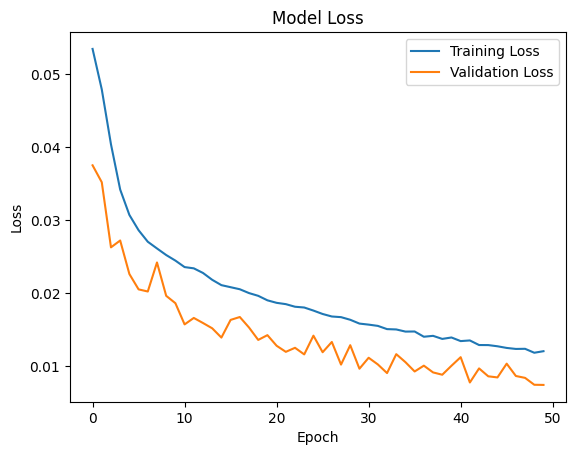

In [27]:
import matplotlib.pyplot as plt

# Plot training and validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [28]:
#Prediction and performance metrics
train_prediction = model.predict(x_train)
test_prediction = model.predict(x_test)

764/764 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step
326/326 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


In [29]:
#Calculate RMSE performance metric
import math
from sklearn.metrics import mean_squared_error

train_rmse = math.sqrt(mean_squared_error(y_train, train_prediction))
test_rmse = math.sqrt(mean_squared_error(y_test, test_prediction))

print(f'Training Data RMSE: {train_rmse}')
print(f'Test Data RMSE: {test_rmse}')

Training Data RMSE: 0.09316698007174556
Test Data RMSE: 0.08648355364950813


In [30]:
#Calculate MAE performance metric
from sklearn.metrics import mean_absolute_error

train_mae = mean_absolute_error(y_train, train_prediction)
test_mae = mean_absolute_error(y_test, test_prediction)

print(f'Training Data MAE: {train_mae}')
print(f'Test Data MAE: {test_mae}')

Training Data MAE: 0.05462374740076526
Test Data MAE: 0.04480291767202581


In [31]:
#Calculate MSE performance metric
train_mse = mean_squared_error(y_train, train_prediction)
test_mse = mean_squared_error(y_test, test_prediction)

print(f'Training Data MSE: {train_mse}')
print(f'Test Data MSE: {test_mse}')

Training Data MSE: 0.008680086175689035
Test Data MSE: 0.007479405051847352


In [32]:
#Calculate R2 performance metric
from sklearn.metrics import r2_score

train_r2_score = r2_score(y_train, train_prediction)
test_r2_score = r2_score(y_test, test_prediction)

print(f'Training Data r-squared: {train_r2_score}')
print(f'Test Data r-squared: {test_r2_score}')

Training Data r-squared: 0.8190190153768684
Test Data r-squared: 0.8066376777837087


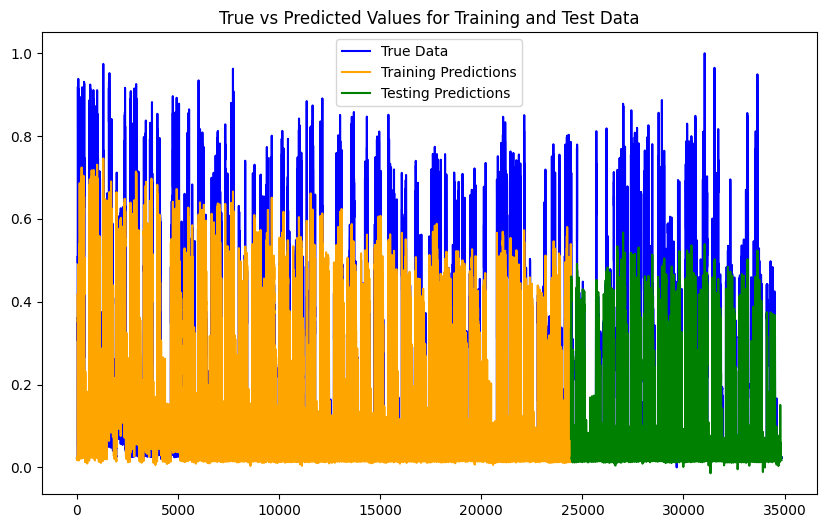

In [33]:
#Plot predictions against actual values

time_step = 95
train_prediction_plot = np.empty_like(np.concatenate([y_train, y_test]))
train_prediction_plot[:] = np.nan
train_prediction_plot[:len(train_prediction)] = train_prediction.flatten()

test_prediction_plot = np.empty_like(np.concatenate([y_train, y_test]))
test_prediction_plot[:] = np.nan
test_prediction_plot[len(train_prediction):] = test_prediction.flatten()

actual_values = np.concatenate([y_train, y_test])

plt.figure(figsize=(10,6))
plt.plot(actual_values, label = 'True Data', color='blue')
plt.plot(train_prediction_plot, label = 'Training Predictions', color='orange')
plt.plot(test_prediction_plot, label='Testing Predictions', color='green')

plt.xlabel=('Time Steps')
plt.ylabel=('Value')
plt.title('True vs Predicted Values for Training and Test Data')
plt.legend()

plt.show()

In [34]:
#Next 25 predictions using most recent test_data

output_list = []
i = 0
n_steps = 95
predictions = 100
test_input = test_data.to_numpy()
test_length = len(test_input)

start_value = test_length-n_steps-predictions
end_value = test_length-predictions

x_input = test_input[start_value:end_value, 1:]

while (i < 100):

    x_input = x_input.reshape((1, 95, 14))
    
    #store prediction in output list
    next_pred = model.predict(x_input)
    output_list = np.append(output_list, next_pred[0,0])

    #slide test_data window by 1 row
    x_input = x_input.reshape(95, 14)
    x_input = np.append(x_input[1:], test_input[start_value + i, 1:].reshape(1, -1), axis=0)

    i = i + 1

print(output_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [35]:
#Function to inverse transform array of values

def inverse_transform(array, num_features):
    dummy_array = np.zeros((len(array), num_features))
    dummy_array[:,0] = array

    original_values = scaler.inverse_transform(dummy_array)
    original_array = original_values[:,0]

    return original_array

In [36]:
#convert predictions to original values

transformed_output_list = inverse_transform(output_list, 7)
print(transformed_output_list)

[ 3.35471034  3.2671614   3.13150675  3.10264777  3.20348966  3.27890736
  3.32622728  3.20442184  3.21779912  3.24921808  3.26154021  3.1221217
  3.13769826  3.17449484  3.18897878  3.05772622  3.09617754  3.15411098
  3.18880078  3.0959808   3.1848917   3.2864058   3.36441276  3.33777766
  3.4732508   3.57431286  3.60658437  3.47686125  3.34857153  2.99442806
  2.53445154  2.32653057  2.39546633  2.42216466  2.56708609  7.53675048
 11.87040713 12.43988453  8.90183189  9.31941054  6.35496805  2.61933509
  0.5109912   5.57422859  5.25766046  1.93329988  1.24147016  4.58465295
  5.1947306   5.35875355  5.66425495  4.31429807  3.88584416  3.97727055
  4.04763152  4.03285129  4.12180435  4.13312989  4.07411437  4.06323736
  4.07691326  3.96110728  3.84887661  4.00723855  4.15631381  4.08152966
  3.95605757  4.04217662  4.08768253  3.99844723  3.95088139  3.9977036
  4.04159225  4.00825973  4.03829448  4.06399388  4.14060608  4.17707827
  4.19929018  4.17244078  4.20261079  4.20735426  4.2

In [37]:
# Assuming y_test contains the actual data (last 95 values in the normalized scale)
previous_600_normalized = y_test[-600:]  # Last 95 normalized Usage_kWh

previous_600_actual = inverse_transform(previous_600_normalized, 7)

# Now, plot the actual and predicted values together
print(previous_600_actual[:25])

[3.38 3.74 4.1  4.18 4.1  4.18 3.64 3.46 3.46 3.38 3.42 3.42 3.42 4.03
 4.14 3.49 3.2  3.85 3.89 3.89 3.85 3.64 3.31 3.13 3.24]


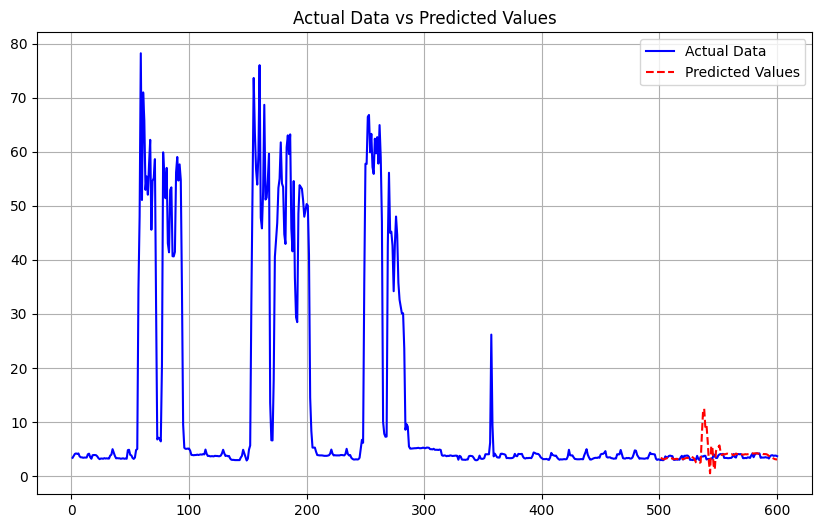

In [38]:
# Plot previous 95 and next 25 predictions
import matplotlib.pyplot as plt

days = np.arange(1, 601)
predicted_days = np.arange(501, 601)

plt.figure(figsize=(10, 6))
plt.plot(days, previous_600_actual, label="Actual Data", color='blue')

# Plot the predicted values for the last 95 days
plt.plot(predicted_days, transformed_output_list, label="Predicted Values", color='red', linestyle='--')

# Adding labels and title
plt.title("Actual Data vs Predicted Values")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()